In [2]:
# 데이터 다운로드
!kaggle competitions download -c bike-sharing-demand


  0%|          | 0.00/189k [00:00<?, ?B/s]
100%|##########| 189k/189k [00:00<00:00, 10.8MB/s]


### Data Fields
- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather    
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

### Evaluation
Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE). 

과거 사용 패턴 + 날씨에 따른 자전거 대여량 예측 → 회귀 

In [9]:
# 패키지 불러오기
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프 그리기 
%matplotlib inline

# 그래프 스타일 설정
plt.style.use('ggplot')

# 그래프 마이너스 폰트 깨짐 설정
mpl.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기
train = pd.read_csv("./bike-sharing-demand/train.csv", parse_dates=['datetime'])

In [10]:
# 데이터 확인하기
train.shape

(10886, 12)

10886개의 데이터와 12개의 특성이 존재한다

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [12]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


<AxesSubplot:>

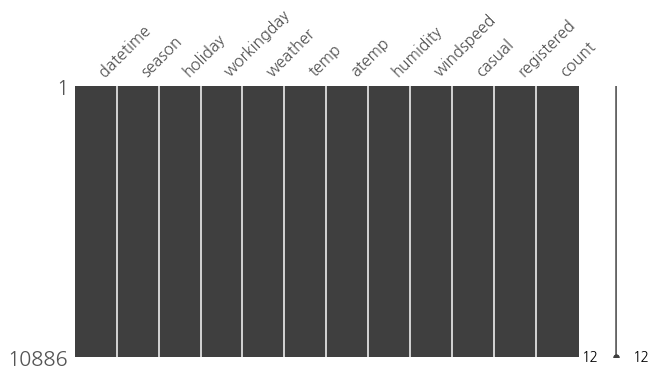

In [14]:
# 결측치 시각화
import missingno as msno
msno.matrix(train, figsize=(10,5))

결측치는 없는 것을 확인할 수 있다.

In [15]:
# 날짜 데이터 분리
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train.shape

(10886, 18)

In [16]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


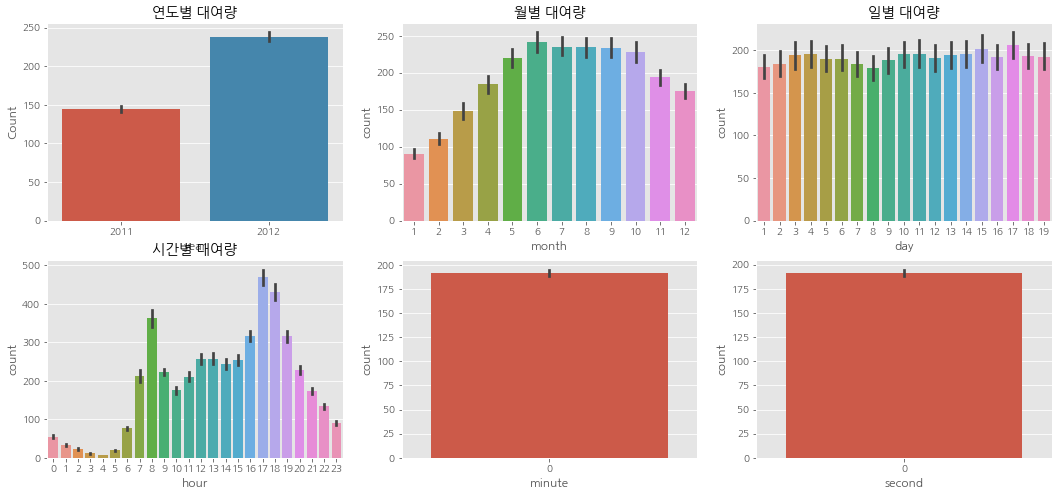

In [18]:
# 시간 변수 별 대여량 시각화
figure, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,8)

sns.barplot(data=train, x='year', y='count', ax=ax1)
sns.barplot(data=train, x='month', y='count', ax=ax2)
sns.barplot(data=train, x='day', y='count', ax=ax3)
sns.barplot(data=train, x='hour', y='count', ax=ax4)
sns.barplot(data=train, x='minute', y='count', ax=ax5)
sns.barplot(data=train, x='second', y='count', ax=ax6)

ax1.set(ylabel='Count', title='연도별 대여량')
ax2.set(xlabel='month', title='월별 대여량')
ax3.set(xlabel='day',title='일별 대여량')
ax4.set(xlabel='hour', title='시간별 대여량')

plt.show()

- 연도별 대여량은 2011년보다 2012년이 더 많다.
- 월별 대여량은 6월이 가장 많고 7-10월도 6월과 비슷하다. 가장 적은 달은 1월이다.
- 일별 대여량은 1-19일까지만 존재하고 나머지 날짜는 test.csv에 존재한다. 이 데이터는 피처로 사용 X
- 시간별 대여량을 보면 출퇴근 시간에 대여량이 많은 것 같다. 주말과 분리해서 볼 필요가 있다.
- 분,초 데이터는 모두 0이므로 의미가 없다.

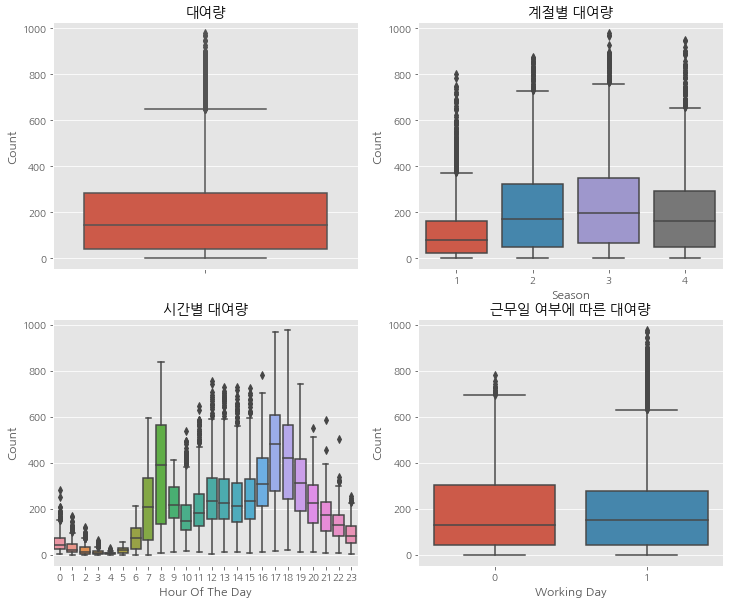

In [21]:
# 대여량, 계절별 대여량, 시간별 대여량, 근무일 여부에 따른 대여량 시각화
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12,10)
sns.boxplot(data=train, y='count', orient='v', ax=axes[0][0])
sns.boxplot(data=train, y='count', x='season', orient='v', ax=axes[0][1])
sns.boxplot(data=train, y='count', x='hour', orient='v', ax=axes[1][0])
sns.boxplot(data=train, y='count', x='workingday', orient='v', ax=axes[1][1])

axes[0][0].set(ylabel='Count', title='대여량')
axes[0][1].set(xlabel='Season', ylabel='Count', title='계절별 대여량')
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count', title='시간별 대여량')
axes[1][1].set(xlabel='Working Day', ylabel='Count',title='근무일 여부에 따른 대여량')

plt.show()

- 대여량은 50-300정도의 특정 구간에 몰려있는 것을 확인할 수 있다.
- 계절별 대여량은 봄에 가장 적고 여름,가을에 많다.
- 시간별 대여량은 출퇴근 시간에 가장 많은 것 같다.
- 근무일 여부에 따른 대여량은 유의미한 차이가 없다. 

In [23]:
# 요일 변수 추가
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [24]:
train['dayofweek'].value_counts()

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

요일별로 큰 차이는 없는 것으로 보인다

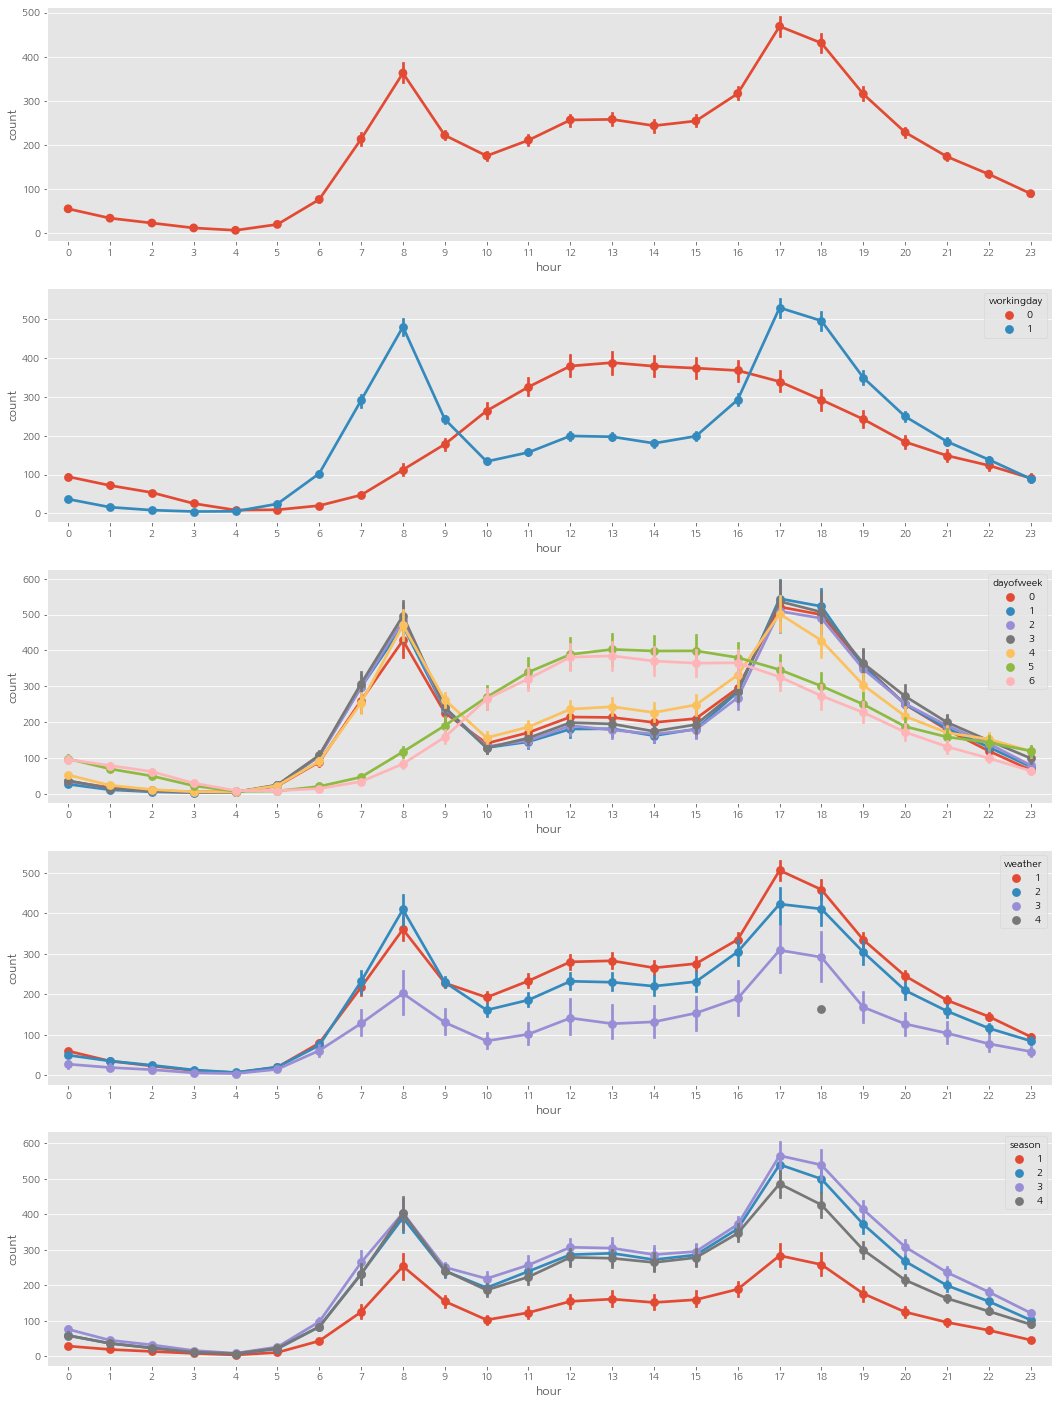

In [25]:
# 시간대 별 대여량을 근무일 여부, 요일, 날씨, 계절별로 시각화
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.pointplot(data=train, x='hour', y='count', ax=ax1)
sns.pointplot(data=train, x='hour', y='count', hue='workingday', ax=ax2)
sns.pointplot(data=train, x='hour', y='count', hue='dayofweek', ax=ax3)
sns.pointplot(data=train, x='hour', y='count', hue='weather', ax=ax4)
sns.pointplot(data=train, x='hour', y='count', hue='season', ax=ax5)

plt.show()

- 휴일의 경우 오후시간대에 대여량이 증가하는 것을 확인할 수 있다.
- 요일별로 봤을 때도, 월-금에는 출퇴근 시간에 대여량이 증가하고 토,일에는 오후시간대에 대여량이 증가함을 확인할 수 있다.
- 날이 맑을 때 대여량이 대체적으로 많고, 흐릴때, 약한 눈/비가 올 때는 대여량이 감소하는 경향을 확인할 수 있다.    
시간대별로는 출퇴근시간에 대여량이 증가하는 경향이 있다.
- 봄에 가장 대여량이 적고 가을,여름,겨울 순으로 대여량이 많다.  
시간대별로는 출퇴근시간에 대여량이 증가하는 경향이 있다.

In [26]:
# 변수들 간 상관관계 학인
corrMatt = train[['temp', 'atemp', 'casual', 'registered', 'humidity', 'windspeed', 'count']]
corrMatt = corrMatt.corr()
print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.017852   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.057473   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.092276   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091052   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.318607   
windspeed  -0.017852 -0.057473  0.092276    0.091052 -0.318607   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.101369   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.101369  
count       1.000000  


<AxesSubplot:>

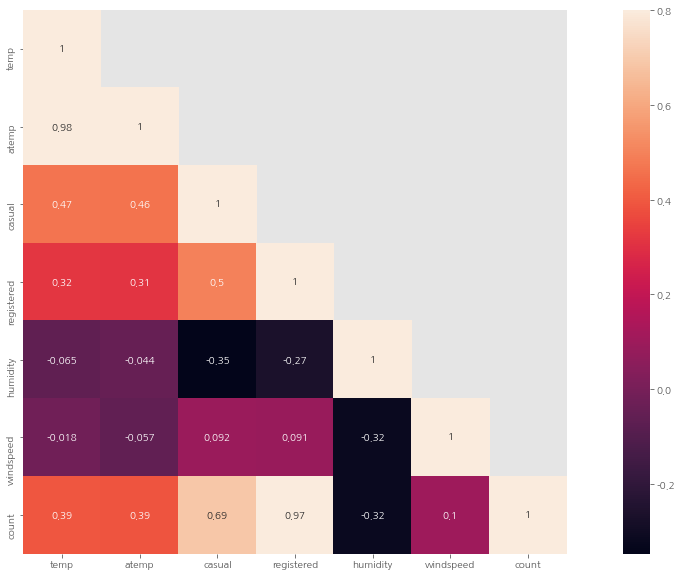

In [27]:
# 상관관계 히트맵으로 시각화 
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True, annot=True)

- temp(온도),atemp(체감온도), humidity(습도), windspeed(풍속)는 대여량과 상관관계가 거의 없다.
- 대여량과 연관관계가 높은 것은 casual(미등록)과 registered(등록)인데 test데이터에는 이 값이 없다.
- temp와 atemp 간의 상관관계가 0.98로 매우 높아 feature로 사용하기에 적합하지 않을 수 있다.

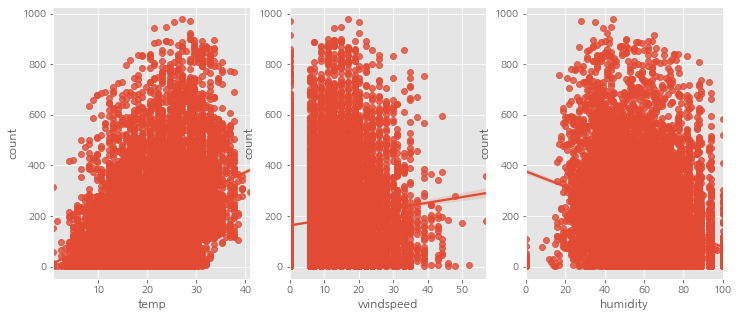

In [28]:
# 온도, 풍속, 습도에 따른 대여량 산점도
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12,5)

sns.regplot(x='temp', y='count', data=train, ax=ax1)
sns.regplot(x='windspeed', y='count', data=train, ax=ax2)
sns.regplot(x='humidity', y='count', data=train, ax=ax3)

plt.show()

- 풍속의 경우 0에 많은 데이터가 몰려 있는 것으로 보인다. 아마 관측되지 않은 수치에 대해 0으로 기록된 것이 아닐까 추측해본다.
- 습도의 경우도 0과 100에 데이터가 조금 몰려 있는 것을 볼 수 있다.

In [29]:
# 연도-월 연결 데이터 
def concatenate_year_month(datetime):
    return '{0}-{1}'.format(datetime.year, datetime.month)

train['year_month'] = train['datetime'].apply(concatenate_year_month)

print(train.shape)
train[['datetime','year_month']].head()

(10886, 20)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


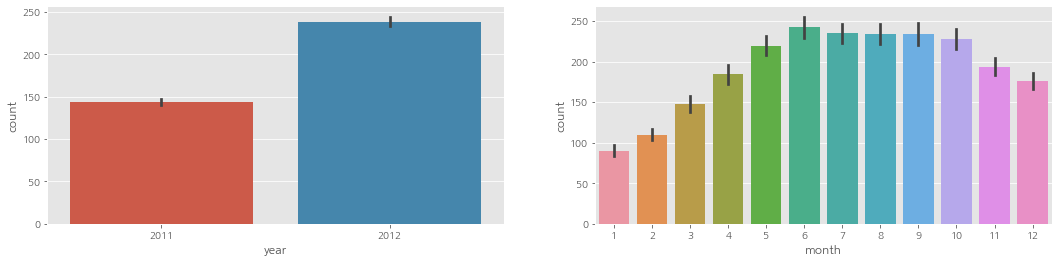

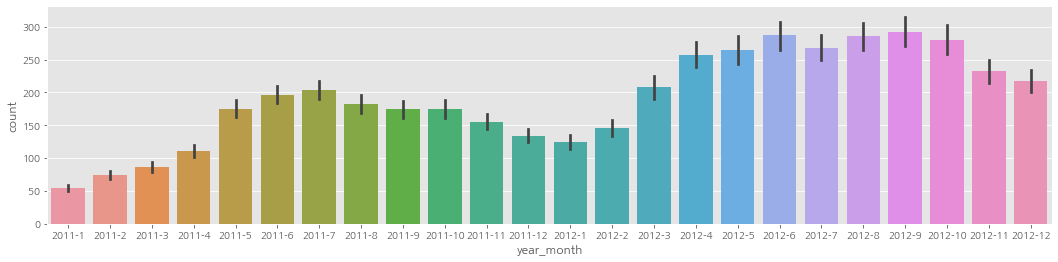

In [32]:
# 연도별, 월별, 연도-월별 대여량 시각화
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18,4)

sns.barplot(data=train, x='year', y='count', ax=ax1)
sns.barplot(data=train, x='month', y='count', ax=ax2)

fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18,4)

sns.barplot(data=train, x='year_month', y='count', ax=ax3)

plt.show()

- 2011년과 2012년의 월별 데이터를 이어보면 전체적으로 증가하는 추세이다.
- 2011년 1월과 2012년 1월을 비교해보면 2배이상 증가한 것을 확인할 수 있다.

In [33]:
# 이상치 제거
trainWithoutOutliers = train[np.abs(train['count'] - train['count'].mean()) <= (3*train["count"].std())]

print(train.shape)
print(trainWithoutOutliers.shape)

(10886, 20)
(10739, 20)


10886 → 10739로 약 150개 정도의 이상치 데이터가 제거되었다.

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


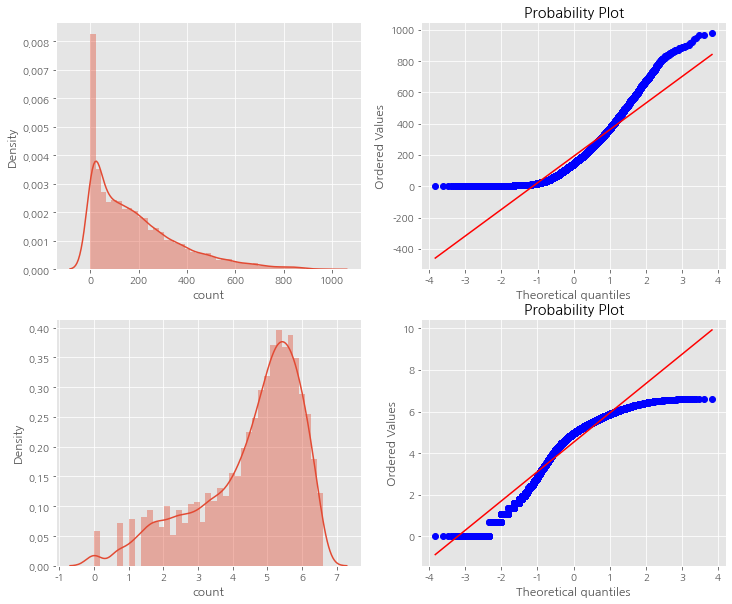

In [36]:
# count값의 데이터 분포도 파악
figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12,10)

sns.distplot(train['count'], ax=axes[0][0])
stats.probplot(train['count'], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(trainWithoutOutliers['count']), ax=axes[1][0])
stats.probplot(np.log(trainWithoutOutliers['count']), dist='norm', fit=True, plot=axes[1][1])

plt.show()

count 변수가 왼쪽으로 치우쳐져 있다. 대부분의 기계학습은 종속변수가 normal이어야 하기에 정규분포를 갖는 것이 바람직하다. 대안으로 outlier data를 제거하고 'count'변수에 로그를 씌워 변환해보아도 정규분포를 따르지는 않지만 이전 그래프보다는 좀 더 자세히 표현하고 있다.